# PyTorch Computer Vision

* See reference notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb 
* See reference online book - https://www.learnpytorch.io/03_pytorch_computer_vision/

## 0. Computer vision libaries in PyTorch

* [`torchvision`](https://www.learnpytorch.io/03_pytorch_computer_vision/) - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cpu
0.19.0+cpu


## 1. Getting a dataset

The dataset we'll be using is FashionMNIST from torchvision.datasets - https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST 

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # should we download the data?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/target?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:04<00:00, 5827312.08it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 131420.00it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [01:20<00:00, 54658.14it/s] 


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [12]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [19]:
class_names = train_data.classes

In [14]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.1 Check input and output shapes of data

In [20]:
# Check the shape of the image
print(f"Image shape: {image.shape} -> [color channel, height, width]")
print(f"Image Label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color channel, height, width]
Image Label: Ankle boot


### 1.1 Visualizing our data

Image shape: torch.Size([1, 28, 28])


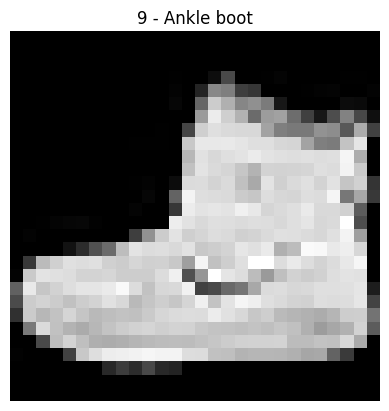

In [32]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap='gray')
plt.title(str(label) + " - " + class_names[label])
plt.axis('off');

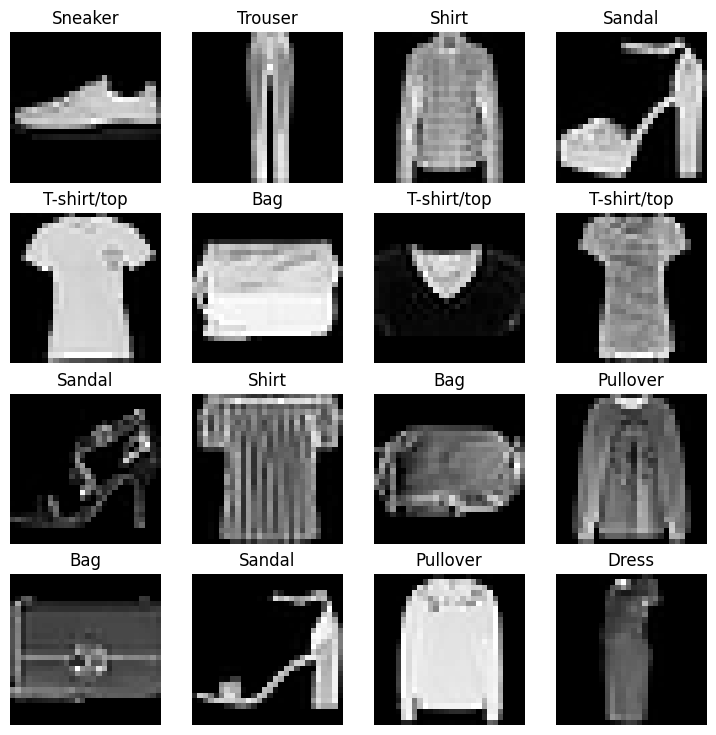

In [48]:
# Plot more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, columns = 4, 4
for i in range(1, rows*columns+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

Do you think these items of clothing (images) could be modelled with pure linear lines? Or do you think we'll need non-linearities?

In [50]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32). 
2. It gives our neural network more chances to update its gradients per epoch.

For more on mini-batches, see here: https://youtu.be/l4lSUAcvHFs

In [59]:
# Turn train dataset into DatLoader
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [60]:
# Let's check out what we've created
print(f"DataLoaders: {train_dataloader}, {test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: <torch.utils.data.dataloader.DataLoader object at 0x0000010BCDC882E0>, <torch.utils.data.dataloader.DataLoader object at 0x0000010BCDC6E220>
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [106]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 2, label size: torch.Size([])


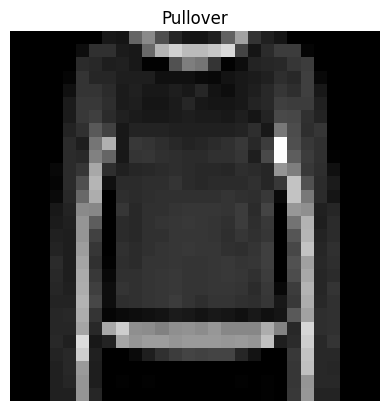

In [123]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")